## Tutorial: Train your  ML model in Azure


This notebook contains an end-to-end walkthrough of submitting GPU intensive job using Azure Machine Learning service

Steps:

* Intialize an AzureML workspace
* Register a datastore and upload data
* Create an experiment
* Provision a compute target
* Create an Estimator
* Configure and Run
* Hyperparameter Tuning
* Model deployment (optional)


## What is Azure Machine Learning service?
Azure Machine Learning service is a cloud service that you can use to develop and deploy machine learning models. Using Azure Machine Learning service, you can track your models as you build, train, deploy, and manage them, all at the broad scale that the cloud provides.

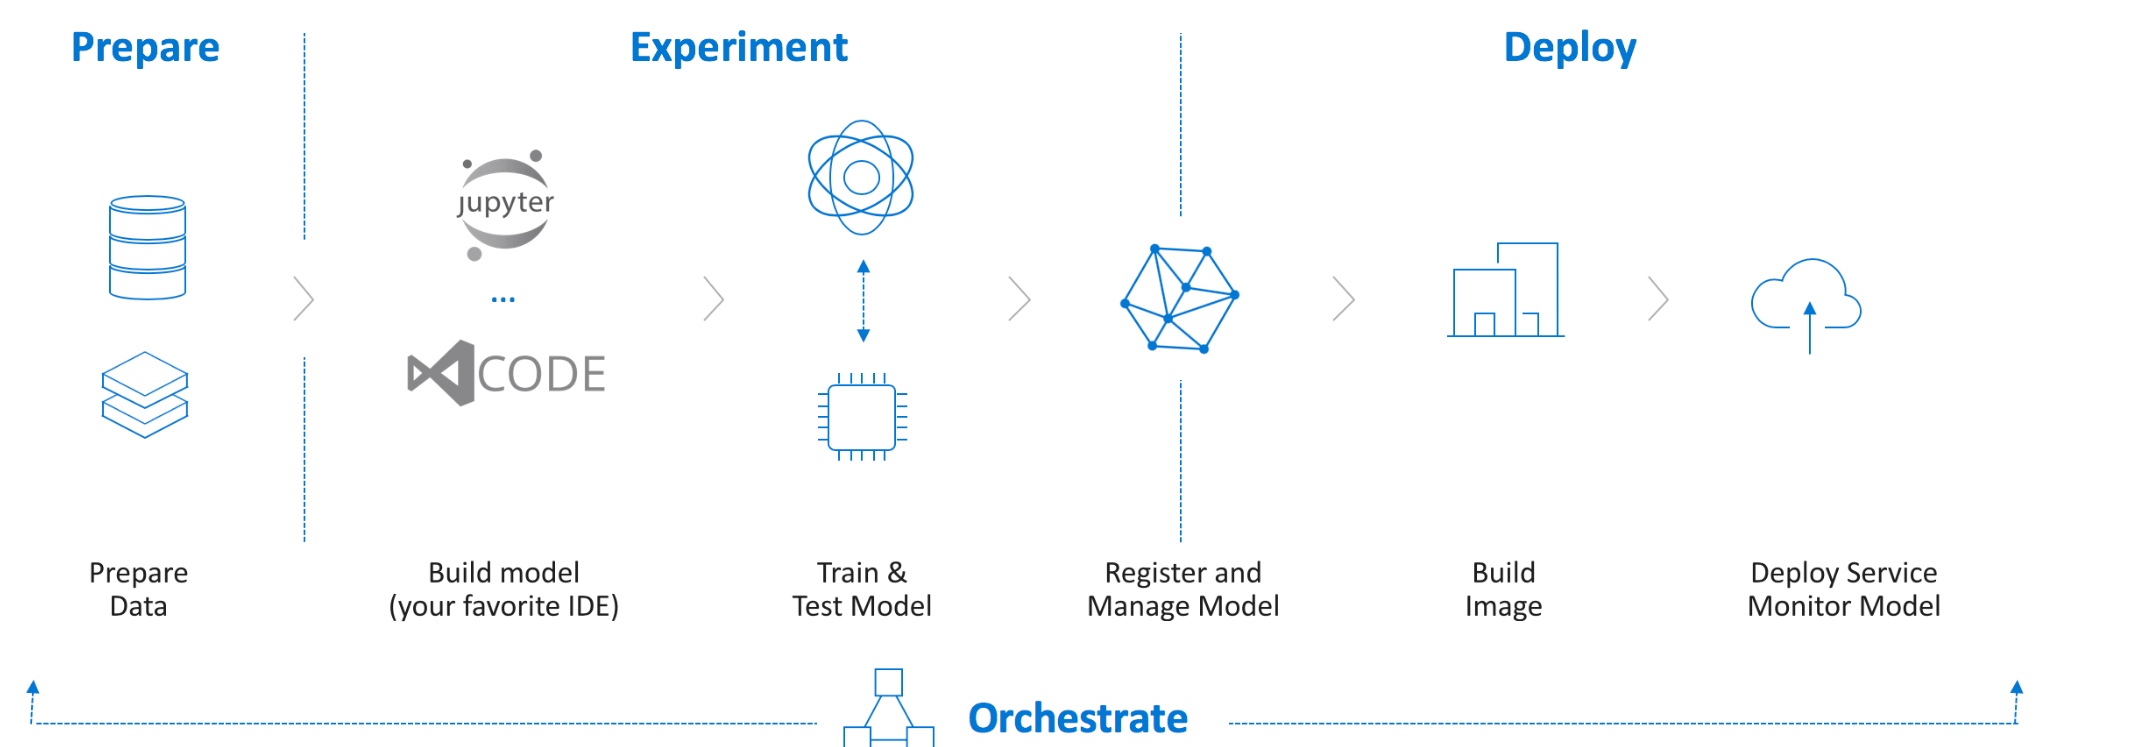

## Setup Python SDK

Setup Conda/Miniconda

Download and install Miniconda. Select the Python 3.7 version or later. Don't select the Python 2.x version.

AzureML Python SDK

Install the Python SDK: make sure to install notebook, and contrib


```console
conda create -n azureml -y Python=3.6 ipywidgets nb_conda
conda activate azureml
pip install --upgrade azureml-sdk[notebooks,contrib] scikit-image tensorflow tensorboardX --user 
jupyter nbextension install --py --user azureml.widgets
jupyter nbextension enable azureml.widgets --user --py
```

You will need to restart jupyter after this Detailed instructions are here: https://docs.microsoft.com/en-us/azure/machine-learning/service/quickstart-create-workspace-with-python

In [33]:
import azureml.core
print("SDK version:", azureml.core.VERSION)

SDK version: 1.4.0


## Connect to ml workspace


The best practice for using Azure ml service is to create one workspace for your v-team, setup your own gpu compute target (though you still need to share quota with other members) and submit your job to that gpu cluster. 

create one ml workspace if not already exists

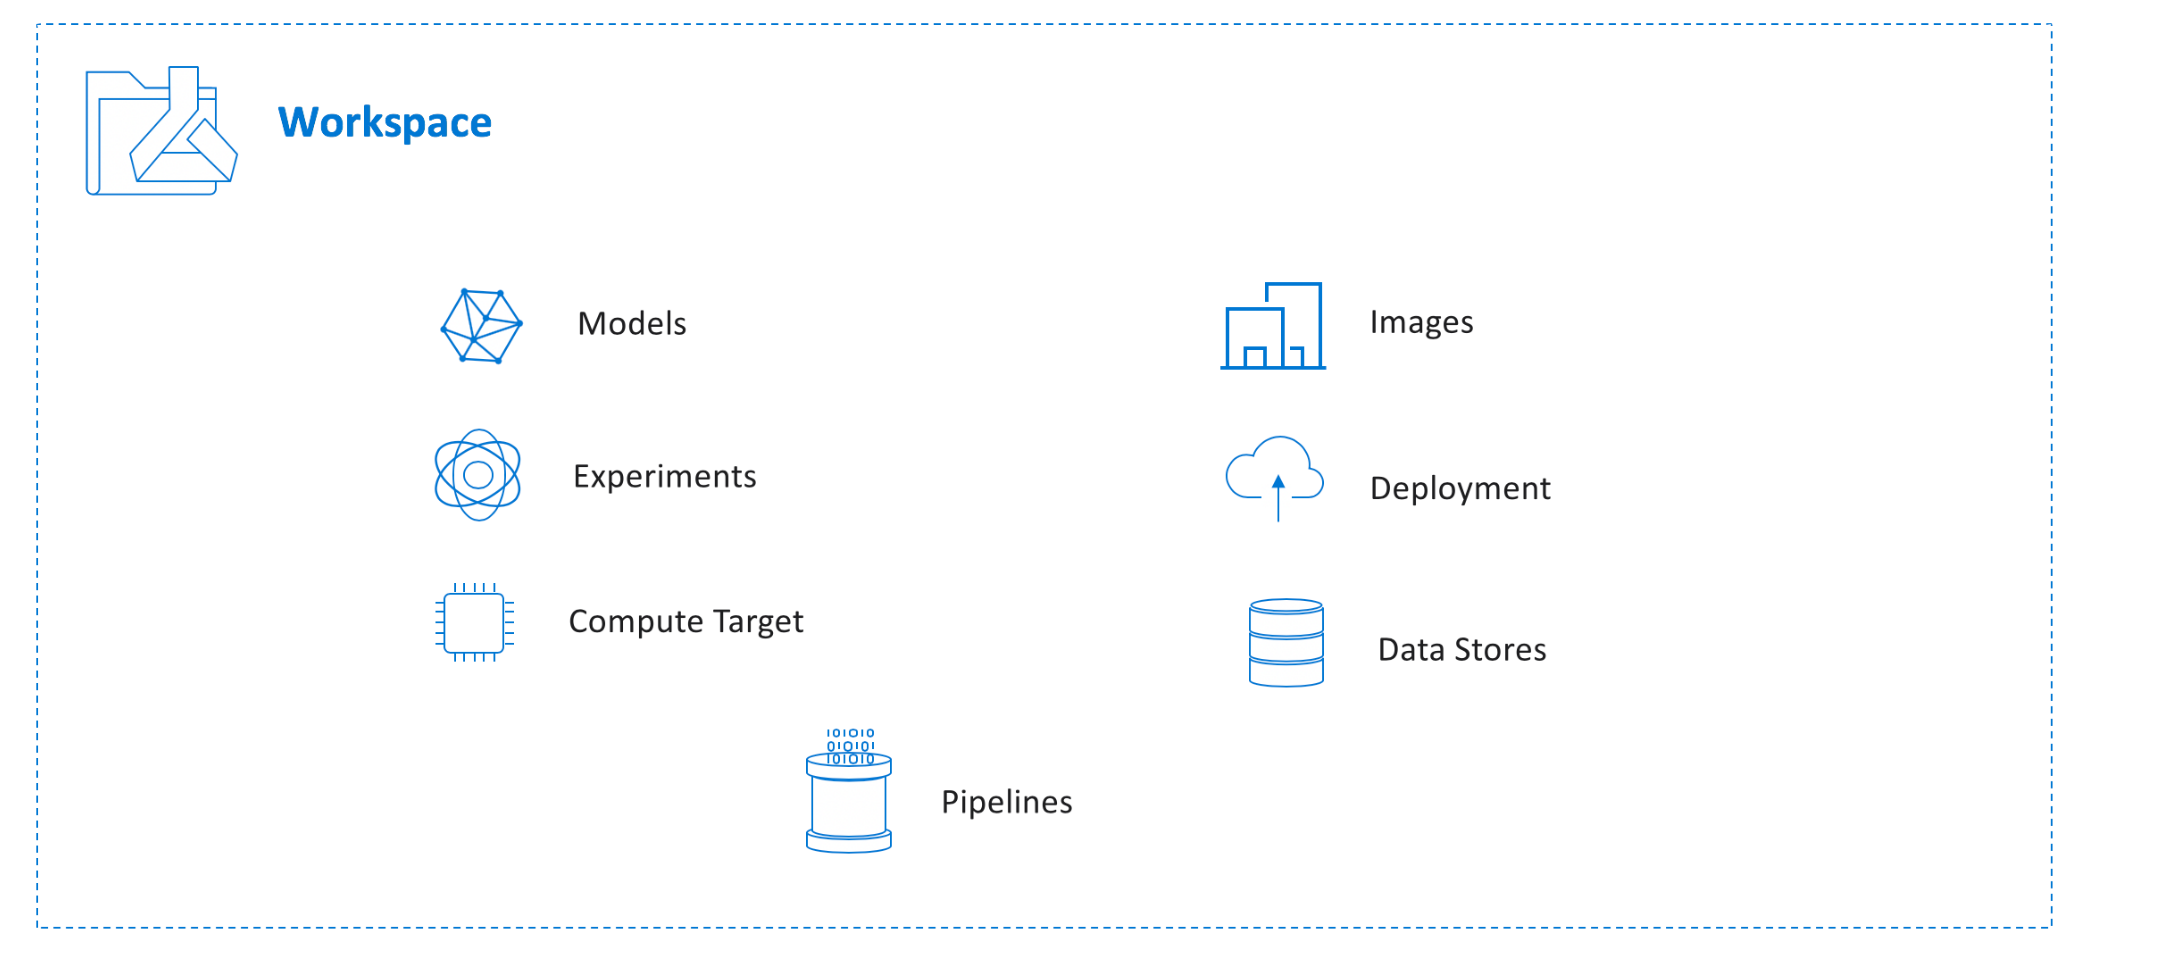

In [34]:
from azureml.core import Workspace

# switch to my own
#WARNING - Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"
#WARNING - You have logged in. Now let us find all the subscriptions to which you have access...
#WARNING - Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"
#Interactive authentication successfully completed.
#Performing interactive authentication. Please follow the instructions on the terminal.
#WARNING - You have logged in. Now let us find all the subscriptions to which you have access...
#Interactive authentication successfully completed.
#Workspace not found
# both group the same


#subscription_id = "4a66f470-dd54-4c5e-bd19-8cb65a426003"
#resource_group  = "AML_Playground"
#workspace_name  = "Teams_ws"

subscription_id = "ddb33dc4-889c-4fa1-90ce-482d793d6480"
resource_group = "DevExp"
workspace_name = "DevExperimentation"



try:
    #print('1')
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    #print('2')
    ws.write_config()
    print('Library configuration succeeded')
    print(ws.get_details()['id'])

    print('https://ms.portal.azure.com/#@microsoft.onmicrosoft.com/resource' + ws.get_details()['id'])
except:
    print('Workspace not found')

Library configuration succeeded
/subscriptions/ddb33dc4-889c-4fa1-90ce-482d793d6480/resourceGroups/DevExp/providers/Microsoft.MachineLearningServices/workspaces/DevExperimentation
https://ms.portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/ddb33dc4-889c-4fa1-90ce-482d793d6480/resourceGroups/DevExp/providers/Microsoft.MachineLearningServices/workspaces/DevExperimentation


In [12]:
#resource group in email inference
{
    "subscription_id": "58f08321-00aa-4ada-bd53-421ecd063782",
    "resource_group": "Compliant_LU",
    "workspace_name": "Teams_ws"
}


{'subscription_id': '58f08321-00aa-4ada-bd53-421ecd063782',
 'resource_group': 'Compliant_LU',
 'workspace_name': 'Teams_ws'}

## Create AmlCompute
Introduction to AmlCompute

Azure Machine Learning Compute is managed compute infrastructure that allows the user to easily create single to multi-node compute of the appropriate VM Family. It is created within your workspace region and is a resource that can be used by other users in your workspace. It autoscales by default to the max_nodes, when a job is submitted, and executes in a containerized environment packaging the dependencies as specified by the user.


In [35]:
from azureml.core.compute import AmlCompute, ComputeTarget

# cluster_name , different from compute name you create
#cluster_name = "p100cluster"
cluster_name = "P100-DualGPU"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    # comment since do not want to create
    #compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6s_v2', 
    #                                                       idle_seconds_before_scaledown=1800,
    #                                                       min_nodes=0, 
    #                                                       max_nodes=10)
    # create the cluster
    #compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    #compute_target.wait_for_completion(show_output=True)

Found existing compute target.


## Connect a datastore and upload data


When you have large data and model, you need to create one seperate Datastore.

If not, AML will have error and you can't track your outputs. 

Each workspace is associated with a default Azure Blob datastore named 'workspaceblobstore'. In this work, we use this default datastore to store our local data.

In [5]:
ds = ws.get_default_datastore()

We can also register a new datastore and link to the existing workspace. Show storge account: https://ms.portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/4a66f470-dd54-4c5e-bd19-8cb65a426003/resourceGroups/AML_Playground/providers/Microsoft.Storage/storageAccounts/teamsws4000114466/overview

In [38]:
# Register the datastore with the workspace
# i have arlead registered through portal so i do not need this
#ds_new = Datastore.register_azure_blob_container(workspace=ws, 
#                                             datastore_name='BERT_Preprocessed_Data',
#                                             container_name='data',
#                                             account_name='<name goes here>', 
#                                             account_key='<key goes here>'
#                                            )

# here to register if not yet through portal  
#ds_new = Datastore.register_azure_blob_container(workspace=ws, 
#                                             datastore_name='chiecha_datastore',
#                                             container_name='chiecha',
#                                             account_name='chiecha', 
#                                             account_key='o+JvX+MkXst5A70VbZAk7zSF6pHAQs5UMWRFC1csQWu61ogEPTaf67i8FZsihSYVaMgx4h99zAAWmoB/9mQWrw=='
#
#                                            )
from azureml.core import Datastore
ds = Datastore.get(ws, 'chiecha_datastore')



### Upload data locally

### Upload Data from aether
In azureml, there is no easy approach to link to cosmos, which makes data access difficulty. A hacky solution is to use aether for data access and data pre-processing. We can do data pre-processing in aether and upload data into Azure Blob

Ref: aether://experiments/a176585f-ab53-47f9-a329-7e77a63f3a9a

An alternative approach is to use visual interface/azure ml pipeline to handle data processing, in that case we won't need aether for feature processing. However, visual interface updates very frequently and only provides limited data sources

In [43]:

#$AZUREML_DATAREFERENCE_e2b58eeb943a48968b3f9e7c5c7a9925
#reference can be used in python module(?? not sure, check in the future) 

#upload local model
##model_path_on_datastore = 'Teams_slot_model' #cased model,vocab is too small? Do not have frequent word like common
##ds_model = ds.path(model_path_on_datastore)
##ds.upload(src_dir=r'D:\dl_repo\Tagging_data\bert-base-English-cased-pytorch',
##          target_path= model_path_on_datastore,
##          overwrite=False,
##          show_progress=True)
##print(ds_model.as_mount())

#upload unsupervised local model
##model_path_on_datastore = 'Communication_slot_model_unsupervised' #cased model,vocab is too small? Do not have frequent word like common
##ds_model_unsupervised = ds.path(model_path_on_datastore)
##ds.upload(src_dir=r'D:\dl_repo\Data_model\Communication_unsupervised',
##          target_path= model_path_on_datastore,
##          overwrite=False,
##          show_progress=True)
##print(ds_model_unsupervised.as_mount())

#upload local data set
##path_on_datastore = 'datasets/Teams_communication'
##ds_data_communication = ds.path(path_on_datastore)
##ds.upload(src_dir=r'D:\dl_repo\Data_model\Communication_data',
##          target_path= path_on_datastore,
##          overwrite=False,
##          show_progress=True)

# files training data source
#path_on_datastore = 'resource/Data'
#ds_data_files = ds.path(path_on_datastore)
#ds.upload(src_dir=r'E:\fileAnswer_data_synthesis\CMF_training\resource\Data',
#          target_path= path_on_datastore,
#          overwrite=False,
#          show_progress=True)

# git data source
path_on_datastore = 'resource/Data'
ds_data_files = ds.path(path_on_datastore)
ds.upload(src_dir=r'E:\CoreScienceDataStaging\datasources\Files\resource\Data',
          target_path= path_on_datastore,
          overwrite=False,
          show_progress=True)





Uploading an estimated of 4 files
Uploading E:\CoreScienceDataStaging\datasources\Files\resource\Data\files_domain_training_answer.tsv
Uploading E:\CoreScienceDataStaging\datasources\Files\resource\Data\files_intent_training.tsv
Uploading E:\CoreScienceDataStaging\datasources\Files\resource\Data\files_slot_training.tsv
Uploading E:\CoreScienceDataStaging\datasources\Files\resource\Data\files_slot_training_uwp.tsv
Uploaded E:\CoreScienceDataStaging\datasources\Files\resource\Data\files_intent_training.tsv, 1 files out of an estimated total of 4
Uploaded E:\CoreScienceDataStaging\datasources\Files\resource\Data\files_slot_training_uwp.tsv, 2 files out of an estimated total of 4
Uploaded E:\CoreScienceDataStaging\datasources\Files\resource\Data\files_domain_training_answer.tsv, 3 files out of an estimated total of 4
Uploaded E:\CoreScienceDataStaging\datasources\Files\resource\Data\files_slot_training.tsv, 4 files out of an estimated total of 4
Uploaded 4 files


$AZUREML_DATAREFERENCE_dad167b7247a4148a2eec38e8f7c1a8a

In [ ]:
# Create an experiment
Create an Experiment to track all the runs in your workspace. 

In [7]:
from azureml.core import Experiment

experiment_name = 'Teams_tutorial' 
experiment = Experiment(ws, name=experiment_name)


## Create a PyTorch estimator
The AML SDK's PyTorch estimator enables you to easily submit PyTorch training jobs for both single-node and distributed runs. For more information on the PyTorch estimator, refer here. The following code will define a single-node PyTorch job.

In [8]:
##BATCH AI
from azureml.train.dnn import PyTorch



script_params = {
    #'--data_dir': ds_data.as_mount(),
    #'--data_dir': 'teams_data', #update for golden data
    '--data_dir': ds_data_communication.as_mount(), #update for communication data
    #'--teacher_model_path':ds_model_pretrained.as_mount(),
    '--teacher_model_path':ds.path(f'bert_data/outputs').as_mount(),
    '--bert_model': ds_model.as_mount(),
    '--task_name':'ner',
    '--output_dir':'./outputs',
    '--do_train':'',
    '--do_eval':'',
    #'--learning_rate':'0.001',#add large learning rate for student model
    '--learning_rate':'1e-4',#smaller learning rate given init
    '--num_train_epochs':'10',
    '--warmup_proportion':'0.1',
    '--max_seq_length':'32',
    '--train_batch_size':'64',
    "--temperature": '1',
    "--alpha": '1',
    "--unsupervised_train_corpus":'./lm_data/train.txt' #add for debug
    
    #'--multi_gpu':'',
}

estimator10 = PyTorch(source_directory='..', 
                    script_params=script_params,
                    compute_target=compute_target, 
                    entry_script='distiller.py',
                    #pip_packages=['pandas','pytorch-pretrained-bert==0.4.0','seqeval==0.0.5'],
                    #pip_packages=['pandas','pytorch-pretrained-bert==0.6.1','seqeval==0.0.5','nltk'],
                    pip_packages=['pandas','transformers','pytorch-pretrained-bert==0.6.1','seqeval==0.0.5','nltk'],
                    use_gpu=True)

# Set up your running environment

You can create your own virtual environment. It takes a while the first time you submit the job. If you do not change dependency, the job submission will be fast.
We can also find the enivronemnt configuration in azure machine learning extension

In [9]:

# here using default mange is enough unless you want to specify the detail
print(estimator10.run_config.environment.docker.base_image)
print(estimator10.conda_dependencies.serialize_to_string())

mcr.microsoft.com/azureml/base-gpu:intelmpi2018.3-cuda9.0-cudnn7-ubuntu16.04
# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - pandas
  - transformers
  - pytorch-pretrained-bert==0.6.1
  - seqeval==0.0.5
  - nltk
  - azureml-defaults
  - torch==1.0
  - torchvision==0.2.1
  - horovod==0.15.2



# Submit and Monitor your run

You can also find your previous runs if your open the azure portal

In [10]:
run = experiment.submit(estimator10)
from azureml.widgets import RunDetails
RunDetails(run).show()

Submitting D:\dl_repo\BERT-NER directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## What happens during a run?
If you are running this for the first time, the compute target will need to pull the docker image, which will take about 2 minutes. This gives us the time to go over how a Run is executed in Azure Machine Learning.


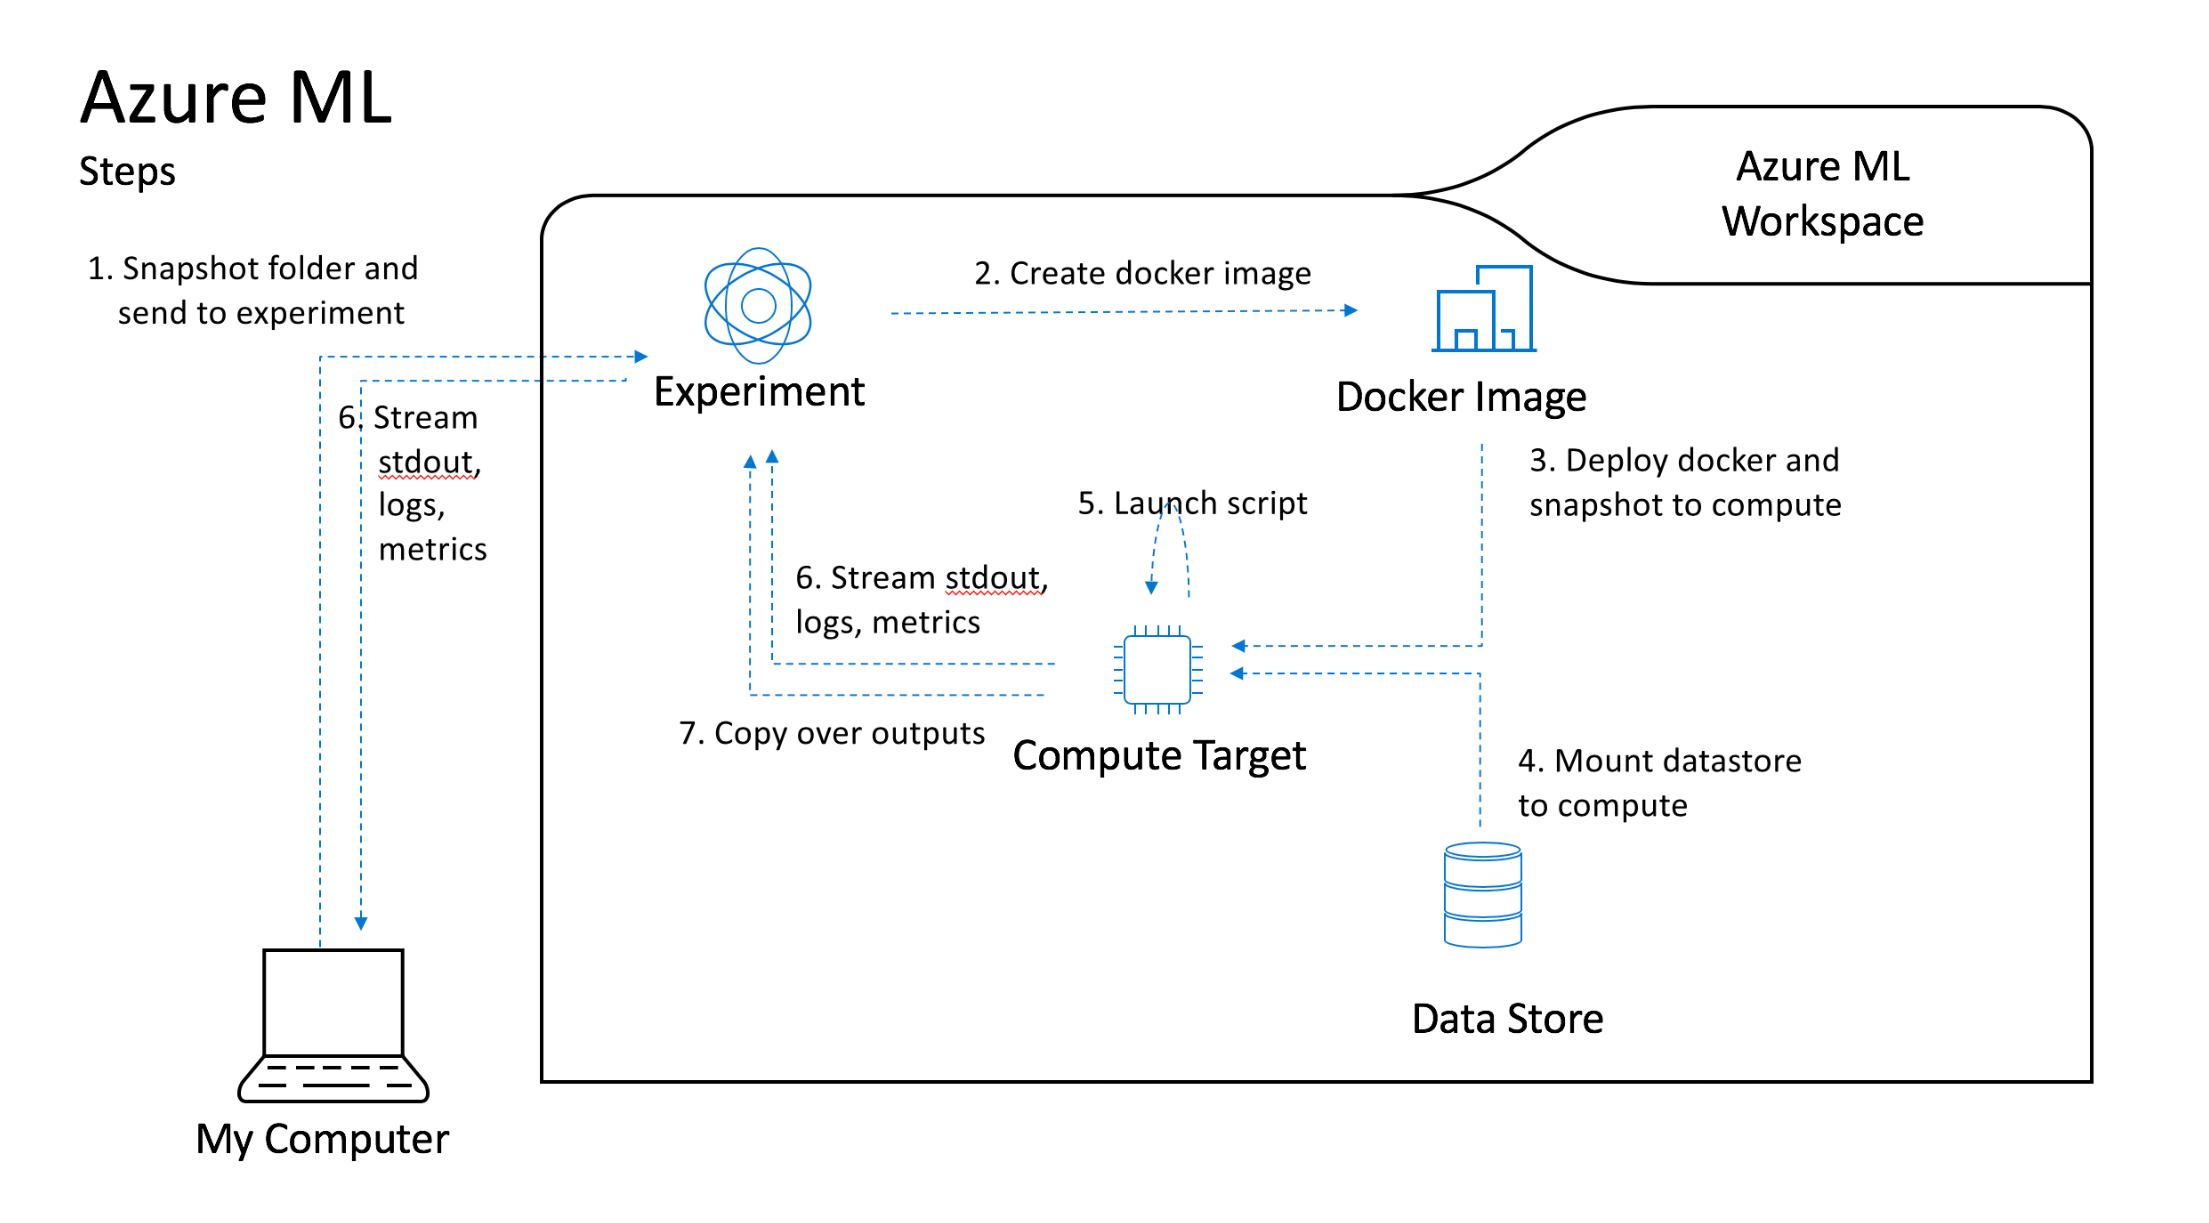

## Hyperparameter Tuning

Now that you have trained an initial model, you can tune the hyperparameters of this model to optimize model performance. Azure ML allows you to automate this tuning, in an efficient manner via early termination of poorly performing runs.

You can configure your Hyperparamter Tuning experiment by specifying the following info -

* Define the hyparparameter space - specify ranges, distribution and sampling
* Early Termination policy
* Optimization metric

Ref: https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.hyperdrive?view=azure-ml-py


In [ ]:
from azureml.widgets import RunDetails
from azureml.train.hyperdrive import *
import math
ps = RandomParameterSampling(
    {
        '--learning_rate': loguniform(math.log(1e-4), math.log(1e-3))
        #'--batch_size': choice(1e-4,2e-4,3e-4,1e-3)
    }
)

policy = BanditPolicy(evaluation_interval=2, slack_factor=0.2)


hdc = HyperDriveConfig(estimator=estimator10, 
                          hyperparameter_sampling=ps, 
                          policy=policy, 
                          primary_metric_name='best_val_f1', 
                          primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                          max_total_runs=4,
                          max_concurrent_runs=4)

In [ ]:
hd_run = experiment.submit(hdc)
RunDetails(hd_run).show()

## Find and register the best model
Once all the runs complete, we can find the run that produced the model with the highest evaluation f1.

ref: https://github.com/microsoft/AzureML-BERT/blob/master/finetune/PyTorch/notebooks/Pretrained-BERT-NER.ipynb

In [ ]:
best_run = hdc.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
print(best_run)
print('Best Run is:\n  F1: {0:.5f} \n  Learning rate: {1:.8f}'.format(
        best_run_metrics['best_val_f1'][-1]
     ))

## Deploy the model 

TODO  :)

https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where

For more advanced tutorials

Ref: https://ml.azure.com/tutorials?wsid=/subscriptions/58f08321-00aa-4ada-bd53-421ecd063782/resourcegroups/Compliant_LU/workspaces/Teams_ws